# Day 28

This is an update from Day 16's analysis which was done through Week 9. 

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Top WRs in 2022

In [77]:
query = """
WITH data AS (
    SELECT
        player_display_name AS player_name,
        week,
        receiving_yards AS rec_yds,
        receiving_tds AS rec_tds,
        receiving_air_yards AS rec_air_yds,
        ROUND(fantasy_points,2) AS pts,
        ROUND(fantasy_points_ppr,2) AS pts_ppr,
        COUNT() OVER(PARTITION BY player_id) AS num_games,
        RANK() OVER(PARTITION BY week ORDER BY receiving_yards DESC) AS r_rec_yds,
        RANK() OVER(PARTITION BY week, position ORDER BY fantasy_points DESC) AS r_pts,
        RANK() OVER(PARTITION BY week, position ORDER BY fantasy_points_ppr DESC) AS r_pts_ppr
    FROM weekly 
    WHERE season = 2022
        AND week <= 11
        AND season_type = 'REG'
)
SELECT *
FROM data
ORDER BY week, r_rec_yds ASC
"""

df_2022 = pd.read_sql(query, conn)

print(df_2022.shape)
df_2022.head()

(3223, 11)


,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts,r_pts_ppr
0,Justin Jefferson,1,184.0,2,118.0,30.4,39.4,10,1,1,1
1,A.J. Brown,1,155.0,0,94.0,15.5,25.5,10,2,11,7
2,Davante Adams,1,141.0,1,177.0,20.1,30.1,10,3,2,3
3,Ja'Marr Chase,1,129.0,1,108.0,18.9,28.9,7,4,3,4
4,Cooper Kupp,1,128.0,1,116.0,18.8,31.8,9,5,4,2


In [78]:
# Subset to the top 5 performers per week
df_top5_by_week = df_2022[df_2022['r_rec_yds'] <= 5]

In [79]:
df_top5_by_week['player_name'].value_counts()[:15]

Justin Jefferson            5
Davante Adams               5
Tyreek Hill                 5
Ja'Marr Chase               3
Cooper Kupp                 3
Stefon Diggs                3
Jaylen Waddle               2
Tee Higgins                 2
A.J. Brown                  2
Travis Kelce                2
Amari Cooper                2
Chris Olave                 2
DeAndre Hopkins             1
Marquez Valdes-Scantling    1
Josh Palmer                 1
Name: player_name, dtype: int64

So we have 12 players (including Tyreek) who have at least two appearances in the top 5 rankings for receiving yards. Six players are tied with 2 appearances each. Let's get the stats of these players so they can be more properly ranked. We only want to keep five of them to round out the top 10 peers.

In [80]:
# From the value counts, get the names of the players with only 2 top 5 appearance
# Subset the data
filter = df_top5_by_week['player_name'].value_counts() == 2

players_one_top5 = df_top5_by_week['player_name'].value_counts()[filter].index

players_one_top5

Index(['Jaylen Waddle', 'Tee Higgins', 'A.J. Brown', 'Travis Kelce',
       'Amari Cooper', 'Chris Olave'],
      dtype='object')

In [81]:
# Get season averages for these players to look for consistency
season_one_top5 = df_2022[df_2022['player_name'].isin(players_one_top5)]\
                    .groupby('player_name')[['rec_yds', 'num_games', 'r_pts_ppr']]\
                    .mean()\
                    .sort_values(['rec_yds'], ascending=False)\
                    .reset_index()\
                    .round(2)
season_one_top5.head()

,player_name,rec_yds,num_games,r_pts_ppr
0,Jaylen Waddle,87.80,10.0,27.5
1,Travis Kelce,85.50,10.0,3.4
2,Tee Higgins,79.11,9.0,27.0
3,A.J. Brown,78.50,10.0,30.9
4,Chris Olave,76.00,10.0,27.8


I'll keep the top 5 by receiving yards.  

With these five players added, we can now compare Tyreek Hill's receiving yards to his top 10 "peers" in the stat. How does he rank week to week?

In [82]:
# Assemble the peer list - the 10 players that challenge Tyreek Hill when it comes to receiving yards
top_10_peers = list(df_top5_by_week['player_name'].value_counts()[df_top5_by_week['player_name'].value_counts() > 2].index)
top_10_peers.pop(2) # remove Tyreek

# Add Waddle and Kelce
for player in list(season_one_top5['player_name'])[0:5]:
    top_10_peers.append(player)

# Validate
print(len(top_10_peers))
top_10_peers

10


['Justin Jefferson',
 'Davante Adams',
 "Ja'Marr Chase",
 'Cooper Kupp',
 'Stefon Diggs',
 'Jaylen Waddle',
 'Travis Kelce',
 'Tee Higgins',
 'A.J. Brown',
 'Chris Olave']

In [83]:
# Assemble the dataset for peers
top_10_peers_by_week = df_2022[df_2022['player_name'].isin(top_10_peers)]\
                    .groupby('week')\
                    .mean()\
                    .reset_index()\
                    .round(3)
top_10_peers_by_week

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_87324/2797914875.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()\


,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts,r_pts_ppr
0,1,111.700,0.800,91.500,16.250,23.950,9.500,23.500,16.500,17.500
1,2,81.200,0.900,126.400,13.160,19.960,9.500,40.700,27.800,26.000
2,3,68.200,0.400,97.000,10.060,15.260,9.500,53.200,29.200,28.700
3,4,93.000,0.300,94.100,11.770,18.570,9.500,21.300,20.000,19.000
4,5,76.556,1.000,75.222,14.024,20.024,9.556,50.000,25.667,23.556
5,6,102.250,0.500,74.875,13.237,20.112,9.375,14.500,15.500,12.125
6,7,101.667,0.333,90.833,12.167,18.500,9.333,9.333,16.000,13.167
7,8,81.375,1.000,99.250,14.250,19.625,9.750,44.500,26.500,25.500
8,9,95.778,0.667,116.667,13.700,20.589,9.778,11.111,10.556,10.778
9,10,80.000,0.375,91.000,10.250,16.250,9.875,69.250,40.125,35.750


In [84]:
# Check Tyreek Hill data
df_2022[df_2022['player_name'] == 'Tyreek Hill']

,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts,r_pts_ppr
12,Tyreek Hill,1,94.0,0,109.0,10.0,18.0,10,13,28,17
317,Tyreek Hill,2,190.0,2,138.0,31.0,42.0,10,1,2,2
724,Tyreek Hill,3,33.0,0,34.0,3.3,5.3,10,89,69,72
945,Tyreek Hill,4,160.0,0,172.0,15.9,25.9,10,2,6,4
1314,Tyreek Hill,5,47.0,0,32.0,6.0,13.0,10,60,41,25
1573,Tyreek Hill,6,177.0,0,181.0,17.7,29.7,10,1,4,3
1872,Tyreek Hill,7,72.0,0,171.0,7.2,14.2,10,23,32,23
2126,Tyreek Hill,8,188.0,0,222.0,19.5,31.5,10,1,5,3
2422,Tyreek Hill,9,143.0,1,112.0,20.3,27.3,10,2,2,2
2743,Tyreek Hill,10,44.0,1,80.0,10.4,15.4,10,53,23,20


It's feast or famine for Tyreek until the last two weeks. When it comes to receiving yards he is either out of the top 10 or in the top 2.

## Conclusion

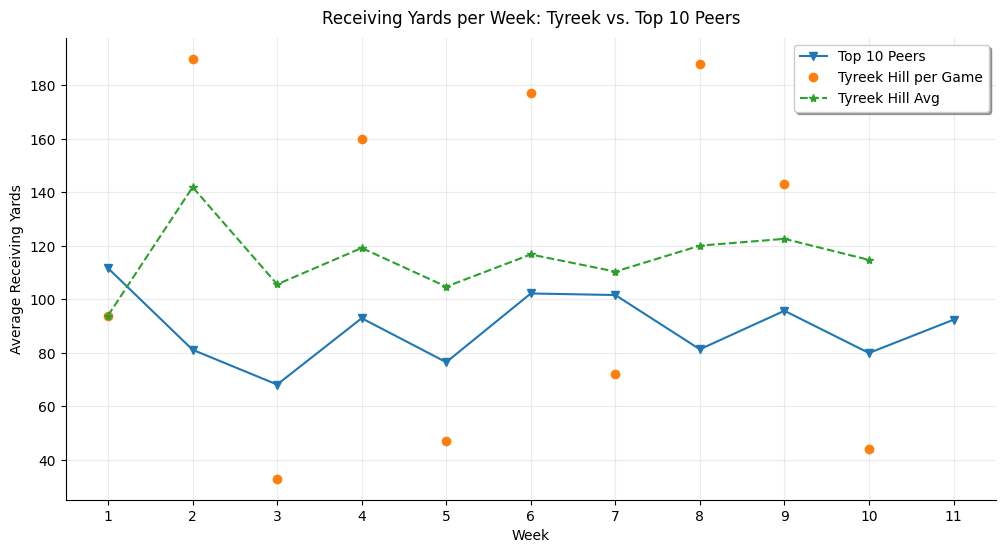

In [85]:
plt.figure(figsize=(12, 6))

plt.plot(
    'week', 
    'rec_yds', 
    data=top_10_peers_by_week,
    marker='v', 
    label='Top 10 Peers')
plt.plot(
    'week', 
    'rec_yds', 
    data=df_2022[df_2022['player_name'] == 'Tyreek Hill'],
    marker='o',
    linestyle='',
    label='Tyreek Hill per Game')
plt.plot(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    list(df_2022[df_2022['player_name'] == 'Tyreek Hill']['rec_yds'].expanding().mean()), # calculate cumulative average
    marker='*',
    linestyle='--',
    label='Tyreek Hill Avg')

plt.xlabel('Week')
plt.ylabel('Average Receiving Yards')
plt.title('Receiving Yards per Week: Tyreek vs. Top 10 Peers', pad=10)

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

plt.legend(frameon=1, facecolor='white', framealpha=1, loc="upper right", shadow=True)
plt.grid(alpha=0.25)
sns.despine()

plt.show()

In [86]:
# Current receiving yards leaders through Week 11
df_2022.groupby('player_name')['rec_yds'].sum().sort_values(ascending=False)[:5]

player_name
Tyreek Hill         1148.0
Justin Jefferson    1093.0
Stefon Diggs        1033.0
Davante Adams        925.0
Jaylen Waddle        878.0
Name: rec_yds, dtype: float64

In 2022, Tyreek Hill has had 5 weekly top 5 performances in terms of receiving yards. He has the highest total receiving yards and yards per game. However, it's been mainly feast or famine for Tyreek - he either completely dominates his competition, or performs below expectations in terms of receiving yards and fantasy points. Still, he's a stud and has been fun to watch this year, especially since he is having a career year on a new team.